In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import camera
from skimage import color, data, io
from skimage.io import imread, imshow, imsave
from skimage.filters import threshold_otsu, threshold_local
import PIL
import os

In [2]:
#function to carry out algorithm
def weng_assessment(img):
    IMG = io.imread(img)
    IMG_ycbcr = color.rgb2ycbcr(IMG)
    
    #convert to YCbCr
    IMG_ycbcr = color.rgb2ycbcr(IMG)
    Y = IMG_ycbcr[:,:,0]
    Cb = IMG_ycbcr[:,:,1]
    Cr = IMG_ycbcr[:,:,2]

    #Find mean values
    Mb = np.mean(Cb)
    Mr = np.mean(Cr)
    
    #Find N, i, j:
    #Code included to calculate N should later iterations of the code 
    # require for image to be divided into 12 sections
    h, w, c = IMG_ycbcr.shape
    N = h*w

    #initialise array for near white pixels
    Db = np.mean(np.absolute(Cb-Mb))
    Dr = np.mean(np.absolute(Cr-Mr))
    
    near_white_db = np.abs(Cb-(Mb+Db*np.sign(Mb))) 
    near_white_dr = np.abs(Cr-(Mr+Dr*np.sign(Mr)))
    near_white_db[near_white_db >= 1.5*Db] = 0
    near_white_dr[near_white_dr >= 1.5*Dr] = 0
    
    near_white_pass = np.multiply(near_white_db, near_white_dr)
    Y_threshold = np.percentile(Y[near_white_pass > 0], 91)
    
    Red = IMG[:,:,0]
    Green = IMG[:,:,1]
    Blue = IMG[:,:,2]

    Red_Adj = Red[Y >= Y_threshold]
    Blue_Adj = Blue[Y >= Y_threshold]
    Green_Adj = Green[Y >= Y_threshold]

    Ravg = np.mean(Red_Adj)
    Gavg = np.mean(Green_Adj)
    Bavg = np.mean(Blue_Adj)

    Ymax = np.amax(Y)

    alpha = Ymax/Ravg
    gamma = Ymax/Gavg
    beta = Ymax/Bavg
    
    #adjusted RGB values 
    Radj = np.clip(alpha*Red, 0, 255).astype('uint8')
    Gadj = np.clip(gamma*Green, 0, 255).astype('uint8')
    Badj = np.clip(beta*Blue, 0, 255).astype('uint8')

    #create new image
    return np.dstack((Radj, Gadj, Badj))

In [3]:
def grey_world_adjustment(img):
    IMG = io.imread(img)
    IMG_lab = color.rgb2lab(IMG)
    
    red_cpt = IMG[:,:,0]
    green_cpt = IMG[:,:,1]
    blue_cpt = IMG[:,:,2]
    
    np.mean(red_cpt)
    np.mean(green_cpt)
    np.mean(blue_cpt)
    
    red_gain = np.mean(green_cpt) / np.mean(red_cpt)
    blue_gain = np.mean(green_cpt) / np.mean(blue_cpt)
    
    adj_red_cpt = red_cpt * red_gain
    adj_blue_cpt = blue_cpt * blue_gain
    
    adj_red_cpt = np.clip(red_cpt * red_gain, 0, 255).astype('uint8')
    adj_blue_cpt = np.clip(blue_cpt * blue_gain, 0, 255).astype('uint8')
    adj_green_cpt = green_cpt # no type conversion required as we have not multiplied by a float

In [4]:
def adjust_image_using_awb_gw(img):
    
    IMG = io.imread(img)
    
    # extract each component from the image
    r = IMG[:,:,0]
    g = IMG[:,:,1]
    b = IMG[:,:,2]
    
    # Grey World gain for red and blue components
    alpha = np.mean(g) / np.mean(r)
    beta = np.mean(g) / np.mean(b)
    
    # adjust by gain, clip to range [0, 255] 
    # convert to unsigned 8-bit integer (unit8) - whole number between 0 and 255
    a_r = np.clip(alpha * r, 0, 255).astype('uint8')
    a_g = g.astype('uint8')
    a_b = np.clip(beta * b, 0, 255).astype('uint8')
    
    # create a colour image by creating a numpy array
    # stacking the adjusted component arrays in depth order
    
    return np.dstack((a_r, a_g, a_b))

In [5]:
def original_RGB_adjustment(img):
    IMG = io.imread(img)
    
    # extract each component from the image
    r = IMG[:,:,0]
    g = IMG[:,:,1]
    b = IMG[:,:,2]
    
    # create a colour image by creating a numpy array
    # stacking the adjusted component arrays in depth order
    
    return np.dstack((r, g, b))

In [6]:
def RGB_histogram_to_Image(img, algorithm, filename):
    _ = plt.hist(img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    _ = plt.hist(img[:, :, 1].ravel(), bins = 256, color = 'green', alpha = 0.5)
    _ = plt.hist(img[:, :, 2].ravel(), bins = 256, color = 'blue', alpha = 0.5)
    _ = plt.xlabel('Level')
    _ = plt.ylabel('Count')
    _ = plt.legend(['Red', 'Green', 'Blue'])
    
    plt.title('RGB Histogram - ' + algorithm +' : '+filename)
    plt.savefig('Outputs/Analysis/'+algorithm+'/RGBHistogram_'+algorithm+'_'+filename+'.png')
    plt.close()

In [7]:
#For loop to cycle through user identified dataset and perform Weng function

directory = 'Datasets/Test/'

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if filename.startswith('test'):
        selected_image = f
        weng_updated_img = weng_assessment(selected_image)
        
        imsave("Outputs/Weng/Weng_Output_" + filename, weng_updated_img)
        
        #Extract histogram from selected image and convert to png
        RGB_histogram_to_Image(weng_updated_img, 'Weng', filename)

In [8]:
#For loop to cycle through user identified dataset and perform GW function

directory = 'Datasets/Test/'

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if filename.startswith('test'):
        selected_image = f
        
        grey_world_adjustment(selected_image)
        gw_updated_img = adjust_image_using_awb_gw(selected_image)
        
        imsave("Outputs/GrayWorld/GW_Output_" + filename, gw_updated_img)
        
        #Extract histogram from selected image and convert to png
        RGB_histogram_to_Image(gw_updated_img, 'GrayWorld', filename)

In [9]:
#Extract RGB Histogram for Original Test Images

directory = 'Datasets/Test/'

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if filename.startswith('test'):
        selected_image = f
        image = original_RGB_adjustment(selected_image)
        RGB_histogram_to_Image(image, 'Original-Test', filename)

In [10]:
#Extract RGB Histogram for Original Truth Images

directory = 'Datasets/Truth/'

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if filename.startswith('true'):
        image = original_RGB_adjustment(selected_image)
        RGB_histogram_to_Image(image, 'Original-True', filename)

In [11]:
def show_images_side_by_side(img_01, img_02):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    ax1.imshow(img_01)
    ax2.imshow(img_02)
    ax1.set_axis_off()
    ax2.set_axis_off()
    plt.show()

In [12]:
def show_RGB_histogram(img):
    _ = plt.hist(img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    _ = plt.hist(img[:, :, 1].ravel(), bins = 256, color = 'green', alpha = 0.5)
    _ = plt.hist(img[:, :, 2].ravel(), bins = 256, color = 'blue', alpha = 0.5)
    _ = plt.xlabel('Level')
    _ = plt.ylabel('Count')
    _ = plt.legend(['Red', 'Green', 'Blue'])
    plt.show()

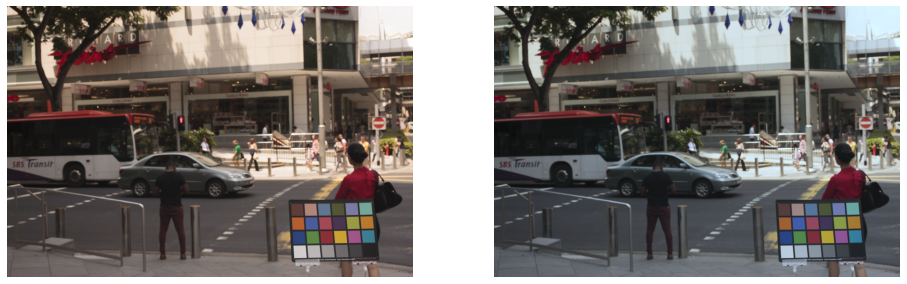

In [13]:
#Including side-by-side analysis cell to allow user to select images to compare as required.
TEST = "Outputs/GrayWorld/GW_Output_test-0072_S_FF.png"
TEST2 = "Datasets/Test/test-0072_S_FF.png"
test = io.imread(TEST)
test2 = io.imread(TEST2)

show_images_side_by_side(test2, test)